<a href="https://colab.research.google.com/github/loluna/for_fun/blob/master/Two_Goal_Lead.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Is 2-0 really the most dangerous lead?

##Introduction

Anyone who has spent time playing or watching football is likley to have heard some variation of the phrase "2-0 is the most dangerous lead". It's a cliche so common it even has a [wikipedia page.](https://en.wikipedia.org/wiki/2–0_lead_is_the_worst_lead)

In the recently released [All or Nothing: Tottenham Hotspur](https://www.imdb.com/title/tt11188556/) documentary, Jose Mourinho, one of the sport's most decorated coaches, can be heard reiterating this statement (albeit in slightly different words). 

In this notebook we set out to fact check this notion. 

To do so we will use the [Football Events](https://www.kaggle.com/secareanualin/football-events) Kaggle dataset which contains match event data such as goals scored from roughly 9,000 games from Europe's top 5 leagues. 

In particular we will examine 3 possible interpretations. 
1.   A team with a 2-0 lead will ultimately lose or draw games more often than with other leads (we'll use 1-0 leads for comparison)
2.   A team with a 2-0 lead is more likely to concede the next goal than with other leads. 
3.   When a team concedes after a 2-0 lead they do so faster than with other leads. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

In [3]:
from google.colab import drive
drive.mount('/content/drive')
events = pd.read_csv("drive/My Drive/events.csv")
game_info = pd.read_csv("drive/My Drive/ginf.csv")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Data manipulation 
This will cut out extra data and create some useful variables.

Let's filter to only for events that correspond to goals. Then let's signify if the goal was a home or away goal. And finally let's convert that to a "running score". 

In [84]:
goals = events.loc[events["is_goal"] == 1, ["id_odsp", "time", "side"]]
goals.loc[goals['side'] == 1, 'home_goals'] = 1
goals.loc[goals['side'] == 2, 'away_goals'] = 1
# Convert NaN to 0
goals.loc[pd.isnull(goals['home_goals']), 'home_goals'] = 0
goals.loc[pd.isnull(goals['away_goals']), 'away_goals'] = 0
# Get running score
goals[["home_goals", "away_goals"]] = goals.groupby("id_odsp")[["home_goals", "away_goals"]].cumsum()

Next let's make a series of variables that show if:


*   a row is an example of 1-0 or 2-0 lead
*   there was a next goal and if so if it was home or away
*   the next goal was a pullback goal - I don't think this is a real term but it's convenient shorthand for 1-0 > 1-1 or 2-0 > 2-1.
*   the home or away team had the lead



*Note: I'm consciously omitting other variations of 2 goal leads such as 3-1 or 4-2 because that's not the saying but also because these scorelines often occur later in a game so they represent a different dynamic.*


In [85]:
# 2 indicators for what type of lead it is an example of (if either)
goals.loc[(goals['home_goals'] == 1) & (goals['away_goals'] == 0) , 'one_example'] = 1
goals.loc[(goals['home_goals'] == 0) & (goals['away_goals'] == 1) , 'one_example'] = 1
goals.loc[(goals['home_goals'] == 2) & (goals['away_goals'] == 0) , 'two_example'] = 1
goals.loc[(goals['home_goals'] == 0) & (goals['away_goals'] == 2) , 'two_example'] = 1
# Get next goal scored
goals[['home_goals_next', 'away_goals_next', "time_next"]] = goals.groupby('id_odsp')[["home_goals", "away_goals", "time"]].shift(periods = -1)
# Indicator for if the next goal scored was a pullback goal
goals.loc[(goals['home_goals'] == 1) & (goals['away_goals'] == 0) & (goals['away_goals_next'] == 1), 'pullback'] = 1
goals.loc[(goals['home_goals'] == 0) & (goals['away_goals'] == 1) & (goals['home_goals_next'] == 1), 'pullback'] = 1
goals.loc[(goals['home_goals'] == 2) & (goals['away_goals'] == 0) & (goals['away_goals_next'] == 1), 'pullback'] = 1
goals.loc[(goals['home_goals'] == 0) & (goals['away_goals'] == 2) & (goals['home_goals_next'] == 1), 'pullback'] = 1
goals.loc[pd.isnull(goals['pullback']), 'pullback'] = 0
# Indicator for who had the dangerous lead
goals.loc[(goals['home_goals'] == 1) & (goals['away_goals'] == 0) , 'lead'] = 'home'
goals.loc[(goals['home_goals'] == 0) & (goals['away_goals'] == 1) , 'lead'] = 'away'
goals.loc[(goals['home_goals'] == 2) & (goals['away_goals'] == 0) , 'lead'] = 'home'
goals.loc[(goals['home_goals'] == 0) & (goals['away_goals'] == 2) , 'lead'] = 'away'

Next we filter down to only the games with either 1-0 or 2-0 leads and merge in game info. And finally we'll make a few more variables including 


*   time to next goal after lead
*   home and away win indicators
*   indicator for if the team with lead ultimately won

*Note: A game can be an example of both types of leads eg. 1-0 and 2-0.* 

In [86]:
# Filter to only games with dangerous lead
relevant_goals = goals[(goals['one_example'] == 1) | (goals['two_example'] == 1)]
rel_goals_game = relevant_goals.merge(game_info, how = "left", on = "id_odsp")
# Time until next goal
rel_goals_game["time_to_next"] = rel_goals_game["time_next"] - rel_goals_game["time"]
# Home and away win indicators
rel_goals_game.loc[rel_goals_game["fthg"] >  rel_goals_game["ftag"], "home_win"] = 1
rel_goals_game.loc[rel_goals_game["fthg"] <=  rel_goals_game["ftag"], "home_win"] = 0
rel_goals_game.loc[rel_goals_game["fthg"] < rel_goals_game["ftag"], "away_win"] = 1
rel_goals_game.loc[rel_goals_game["fthg"] >= rel_goals_game["ftag"], "away_win"] = 0
# Leader win indicator
rel_goals_game.loc[(rel_goals_game["lead"] == "home") & (rel_goals_game["home_win"] == 1), "lead_win"] = 1
rel_goals_game.loc[(rel_goals_game["lead"] == "away") & (rel_goals_game["away_win"] == 1), "lead_win"] = 1
rel_goals_game.loc[pd.isnull(rel_goals_game["lead_win"]), "lead_win"] = 0

And that's all. Now we can see that we have 1 row per example of 2-0 and 1-0 leads. That row has details such who scored the next goal and who ultimatey won the game. 
## Analysis

Now we can actually answer our questions. 

So, is 2-0 the most dangerous lead? As you might have guessed no, or at least this data strongly suggests 1-0 is a much more dangerous lead than 2-0. 

### Winning the game

We can see that teams that took a 1-0 lead in this data set won 69% of the time while teams that took a 2-0 lead won 92% of the time. So 1-0 is a much more dangerous lead than 2-0. 

In [87]:
one_win_rate = rel_goals_game.loc[rel_goals_game["one_example"] == 1, "lead_win"].sum()/rel_goals_game.loc[rel_goals_game["one_example"] == 1, "lead_win"].count()
two_win_rate = rel_goals_game.loc[rel_goals_game["two_example"] == 1, "lead_win"].sum()/rel_goals_game.loc[rel_goals_game["two_example"] == 1, "lead_win"].count()
print('After a 1-0 lead teams win {:2.0%} of games'.format(one_win_rate))
print('After a 2-0 lead teams win {:2.0%} of games'.format(two_win_rate))

After a 1-0 lead teams win 69% of games
After a 2-0 lead teams win 92% of games


But what if the difference is more important under certain circumstances like say if the team with the lead is home or away. 

We can test this and we can see that while the home team is more likely to hold on to a lead, both home and away teams are more likely to hold on to 2-0 leads than 1-0 leads. For example away teams who take a 1-0 lead win about **61%** of games while away teams who take a 2-0 lead win just under **90%** of games. 

In [76]:
display(pd.crosstab(rel_goals_game.loc[rel_goals_game["one_example"] == 1, "lead"], rel_goals_game.loc[rel_goals_game["one_example"] == 1, "lead_win"], normalize = 'index'))
display(pd.crosstab(rel_goals_game.loc[rel_goals_game["two_example"] == 1, "lead"], rel_goals_game.loc[rel_goals_game["two_example"] == 1, "lead_win"], normalize = 'index'))

lead_win,0.0,1.0
lead,,
away,0.381349,0.618651
home,0.257231,0.742769


lead_win,0.0,1.0
lead,,
away,0.103528,0.896472
home,0.060215,0.939785


Similarly if we consider differences between countries we can see that 


1.   Win percentages in both scenario are remarkbly consistent across countries
2.   Win percentages is much higher at ~**90%** compared to ~**70%** in all countries



In [77]:
display(pd.crosstab(rel_goals_game.loc[rel_goals_game["one_example"] == 1, "country"], rel_goals_game.loc[rel_goals_game["one_example"] == 1, "lead_win"], normalize = 'index'))
display(pd.crosstab(rel_goals_game.loc[rel_goals_game["two_example"] == 1, "country"], rel_goals_game.loc[rel_goals_game["two_example"] == 1, "lead_win"], normalize = 'index'))

lead_win,0.0,1.0
country,,
england,0.299252,0.700748
france,0.307165,0.692835
germany,0.326859,0.673141
italy,0.311450,0.688550
spain,0.300215,0.699785


lead_win,0.0,1.0
country,,
england,0.091589,0.908411
france,0.071608,0.928392
germany,0.081081,0.918919
italy,0.073983,0.926017
spain,0.066991,0.933009


### Conceding the next goal

Okay so things aren't looking good for the "2-0 is the most dangerous lead" crowd. But what if we consider not who ultimately wins the game but who scores the next goal. 

Unfortunately things still don't look great. In roughly **38%** of games the team leading 1-0 concedes the next goal while only **29%** of teams with a 2-0 lead concede the next goal. 

*Note that what I calculated here is sum(other team scores next)/sum(total games with lead) so games where there was no next goal are included in the denominator.*

In [17]:
one_pullback_rate = rel_goals_game.loc[rel_goals_game["one_example"] == 1, "pullback"].sum()/rel_goals_game.loc[rel_goals_game["one_example"] == 1, "one_example"].sum()
two_pullback_rate = rel_goals_game.loc[rel_goals_game["two_example"] == 1, "pullback"].sum()/rel_goals_game.loc[rel_goals_game["two_example"] == 1, "two_example"].sum()
print('One goal lead: {:2.1%} vs. Two goal lead: {:2.1%}'.format(one_pullback_rate, two_pullback_rate))

One goal lead: 37.73% vs. Two goal lead: 28.93%


Next if we do home and away comparisons we'll notice similar trends to what we saw previously. Namely, conceding the next goal is much more likely with a 1-0 lead (top chart) than a 2-0 lead (bottom chart) and that if the team with the lead is the home team they are less likely to concede the next goal than if they had that lead away. 

In [78]:
display(pd.crosstab(rel_goals_game.loc[rel_goals_game["one_example"] == 1, "lead"], rel_goals_game.loc[rel_goals_game["one_example"] == 1, "pullback"], normalize = 'index'))
display(pd.crosstab(rel_goals_game.loc[rel_goals_game["two_example"] == 1, "lead"], rel_goals_game.loc[rel_goals_game["two_example"] == 1, "pullback"], normalize = 'index'))

pullback,0.0,1.0
lead,,
away,0.562123,0.437877
home,0.666051,0.333949


pullback,0.0,1.0
lead,,
away,0.664110,0.335890
home,0.736774,0.263226


And similarly if we break it out by country there's a bit more variation between countries this time but the same takeaway is true. Conceding the next goal is more likely with a 1-0 lead (top chart) than a 2-0 lead (bottom chart) across countries. 

In [79]:
display(pd.crosstab(rel_goals_game.loc[rel_goals_game["one_example"] == 1, "country"], rel_goals_game.loc[rel_goals_game["one_example"] == 1, "pullback"], normalize = 'index'))
display(pd.crosstab(rel_goals_game.loc[rel_goals_game["two_example"] == 1, "country"], rel_goals_game.loc[rel_goals_game["two_example"] == 1, "pullback"], normalize = 'index'))

pullback,0.0,1.0
country,,
england,0.643392,0.356608
france,0.631191,0.368809
germany,0.594776,0.405224
italy,0.615021,0.384979
spain,0.631042,0.368958


pullback,0.0,1.0
country,,
england,0.714019,0.285981
france,0.695980,0.304020
germany,0.708709,0.291291
italy,0.713933,0.286067
spain,0.721072,0.278928


###Time to concede a pullback goal
So things are looking pretty bleak for this notion at this point. But let's check one more thing to try to save face for this idea. 

What we'll do here is consider only the games where we know pullback goal occured and compare the distribution of time to that goal since the previous goal. 

Conditional on conceding the next goal, less time to concede that goal could be a plausible (although silly IMO) interpretation of "most dangerous lead". What we see is exactly that, notice the orange bars higher toward the quicker times. Further the mean time to the pullback goal is about 24 minutes for 1-0 leads and about 19 minutes for 2-0. 

That said, this is not exactly unexpected. 2-0 leads tend to occur later in the game than 1-0 leads so there just is less time for a potential follow up goal to happen in the average 2-0 game than the average 1-0 game. 

(array([[0.0225773 , 0.02560851, 0.0176298 , 0.01533026, 0.01073118,
         0.00689862, 0.00533075, 0.00320542, 0.00195112, 0.00062715],
        [0.03338566, 0.0281528 , 0.01936159, 0.01245421, 0.00774464,
         0.00533752, 0.0029304 , 0.00052329, 0.        , 0.        ]]),
 array([-2. ,  7.1, 16.2, 25.3, 34.4, 43.5, 52.6, 61.7, 70.8, 79.9, 89. ]),
 <a list of 2 Lists of Patches objects>)

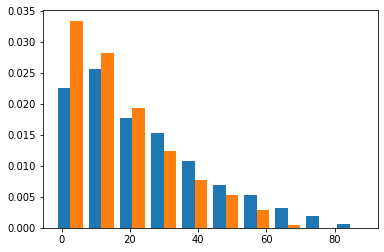

In [101]:
temp_one = np.array(rel_goals_game.loc[(rel_goals_game["one_example"] == 1) & (rel_goals_game["pullback"] == 1) , ["time_to_next"]])
temp_two = np.array(rel_goals_game.loc[(rel_goals_game["two_example"] == 1) & (rel_goals_game["pullback"] == 1), ["time_to_next"]])
plt.hist([temp_one, temp_two], density = True)

In [49]:
mean1 = rel_goals_game.loc[rel_goals_game["one_example"] == 1, ["time_to_next"]].mean()[0]
mean2 = rel_goals_game.loc[rel_goals_game["two_example"] == 1, ["time_to_next"]].mean()[0]
sd1 = rel_goals_game.loc[rel_goals_game["one_example"] == 1, ["time_to_next"]].std()[0]
sd2 = rel_goals_game.loc[rel_goals_game["two_example"] == 1, ["time_to_next"]].std()[0]
print('When teams concede the next goal with a 1-0 lead they do so on average after {:.2f} minutes with standard deviation of {:.2f}'.format(mean1, sd1))
print('When teams concede the next goal with a 2-0 lead they do so on average after {:.2f} minutes with standard deviation of {:.2f}'.format(mean2, sd2))

When teams concede the next goal with a 1-0 lead they do so on average after 23.99 minutes with standard deviation of 18.41
When teams concede the next goal with a 2-0 lead they do so on average after 18.75 minutes with standard deviation of 14.74


## Conclusion
So despite the weak evidence from the time to concede analysis, I think we can safely say 2-0 is not the most dangerous lead. Overwhelmingly teams with 2-0 leads win more often and concede the next goal less often than teams with 1-0 leads. And we haven't even mentioned the well known [truly most dangerous 3-0 lead.](https://en.wikipedia.org/wiki/2018%E2%80%9319_UEFA_Champions_League#Semi-finals)  